In [1]:
import sys
print(sys.executable)

/Users/tanya/coops/readmission/.venv/bin/python


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("diabetic_data.csv")
print("Rows, cols:", df.shape)
df.head()

Rows, cols: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64
readmit_30
0    90409
1    11357
Name: count, dtype: int64


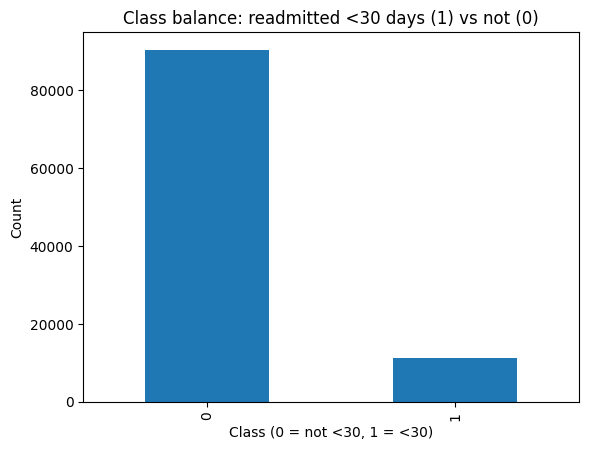

In [3]:
print(df["readmitted"].value_counts())

df["readmit_30"] = (df["readmitted"] == "<30").astype(int)

counts = df["readmit_30"].value_counts().sort_index()
print(counts)

counts.plot(kind="bar")
plt.title("Class balance: readmitted <30 days (1) vs not (0)")
plt.xlabel("Class (0 = not <30, 1 = <30)")
plt.ylabel("Count")
plt.show()

In [4]:
print(df.shape)
df.columns

(101766, 51)


Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'readmit_30'],
      dtype='object')

In [5]:
df[["readmitted", "readmit_30"]].head()

,readmitted,readmit_30
0,NO,0
1,>30,0
2,NO,0
3,NO,0
4,NO,0


In [6]:
df = df.replace("?", pd.NA) # 	pd.NA is pandas’ “this value is missing” object.

In [7]:
missing_rate = df.isna().mean().sort_values(ascending=False) #  # df.isna() creates a same size table of T/F. true when missing. mean gives mean of missing cols. sorting cols from true to false (most missing to least missing).
missing_rate.head(15)



weight               0.968585
max_glu_serum        0.947468
A1Cresult            0.832773
medical_specialty    0.490822
payer_code           0.395574
race                 0.022336
diag_3               0.013983
diag_2               0.003518
diag_1               0.000206
troglitazone         0.000000
encounter_id         0.000000
tolazamide           0.000000
acarbose             0.000000
rosiglitazone        0.000000
pioglitazone         0.000000
dtype: float64

In [8]:
missing_rate.tail(10)

num_medications      0.0
number_outpatient    0.0
number_emergency     0.0
number_inpatient     0.0
number_diagnoses     0.0
metformin            0.0
patient_nbr          0.0
nateglinide          0.0
chlorpropamide       0.0
readmit_30           0.0
dtype: float64

In [9]:
df = df.drop(columns=["weight", "max_glu_serum", "A1Cresult","encounter_id", "patient_nbr",])

df["medical_specialty"] = df["medical_specialty"].fillna("Missing")
df["payer_code"] = df["payer_code"].fillna("Missing")

In [10]:
# 1) Define target y
y = df["readmit_30"].copy()
y = df["readmit_30"]
# 2) Define feature table X (everything except the target + original readmitted label)
X = df.drop(columns=["readmit_30", "readmitted"]).copy()
print("X, y shapes:", X.shape, y.shape)

# 3) Optional: create discharge-time-ish feature set (exclude diagnosis codes for now)
exclude = ["diag_1", "diag_2", "diag_3"]
X_discharge = X.drop(columns=[c for c in exclude if c in X.columns]).copy()
print("X_discharge shape:", X_discharge.shape)

# 4) KNN feature slice (numeric-heavy)
knn_features = [
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
    "number_diagnoses",
]
print("KNN dtypes:\n", df[knn_features].dtypes)

# 5) Save cleaned outputs

df.to_csv("data/diabetic_data_clean_v1.csv", index=False)
X_discharge.to_csv("data/X_discharge_v1.csv", index=False)
y.to_csv("data/y_readmit30_v1.csv", index=False)

X, y shapes: (101766, 44) (101766,)
X_discharge shape: (101766, 41)
KNN dtypes:
 time_in_hospital      int64
num_lab_procedures    int64
num_procedures        int64
num_medications       int64
number_outpatient     int64
number_emergency      int64
number_inpatient      int64
number_diagnoses      int64
dtype: object


In [11]:
import os
print("cwd:", os.getcwd())
print("files:", os.listdir("."))
print("data exists?", os.path.isdir("data"))

cwd: /Users/tanya/Desktop/~:coops:readmission
files: ['IDS_mapping.csv', '\t01_load_and_target.ipynb', 'diabetic_data.csv', '02_knn.ipynb', 'data']
data exists? True


In [12]:
import os
print(os.path.realpath(os.getcwd()))

/Users/tanya/Desktop/~:coops:readmission


In [13]:
import os
print(os.listdir("data"))

['y_readmit30_v1.csv', 'diabetic_data_clean_v1.csv', 'X_discharge_v1.csv']


In [14]:
from pathlib import Path
ROOT = Path.home() / "coops" / "readmission"
(ROOT / "data").mkdir(exist_ok=True)

df.to_csv(ROOT/"data/diabetic_data_clean_v1.csv", index=False)

In [15]:
# if you saved the cleaned data yesterday
df = pd.read_csv("data/diabetic_data_clean_v1.csv")

# sanity check
df["readmit_30"].value_counts(normalize=True)

readmit_30
0    0.888401
1    0.111599
Name: proportion, dtype: float64

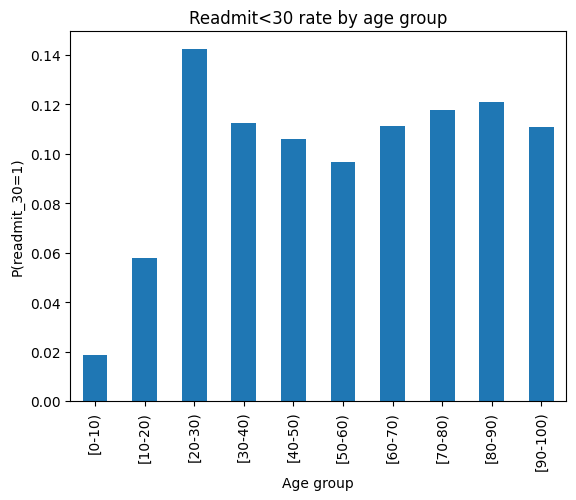

In [16]:
# age groups vs readmit30


# age is a string bin (ex: [30-40), so treat it categorical)
age_rate = df.groupby("age")["readmit_30"].mean().sort_index() # analyze the rows of certain age groups. look at readmit_30 col. gives mean of readmission within age groups. # index gives the labels. sort makes it in logical order
age_rate.plot(kind="bar")
plt.title("Readmit<30 rate by age group")
plt.ylabel("P(readmit_30=1)") # probability of readmit being true (=1)
plt.xlabel("Age group")
plt.show()

# output: the groups with higher rates of readmission are 20-30, 80-90, 70-80. least is 0-10 and 10-20

In [17]:
# can't trust rank ordering UNLESS we check how many rows are each in age group. small sample can make the data spike 

age_stats = df.groupby("age")["readmit_30"].agg(rate="mean", n="size").sort_index()
age_stats

,rate,n
age,,
[0-10),0.018634,161
[10-20),0.057887,691
[20-30),0.142426,1657
[30-40),0.112318,3775
[40-50),0.106040,9685
[50-60),0.096662,17256
[60-70),0.111284,22483
[70-80),0.117731,26068
[80-90),0.120835,17197


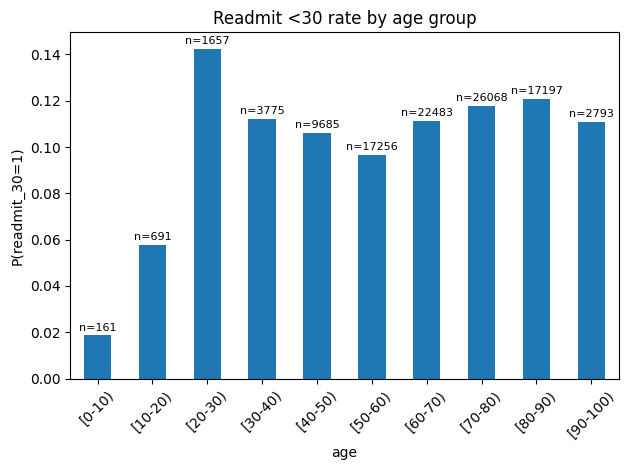

In [18]:
ax = age_stats["rate"].plot(kind="bar", rot=45) # ax = "the specific plot canvas i just drew on" from matplotlib. u can edit the plot with ax.
ax.set_title("Readmit <30 rate by age group")
ax.set_ylabel("P(readmit_30=1)")

for i, (rate, n) in enumerate(zip(age_stats["rate"], age_stats["n"])): # zip pairs values of rate and n together, row by row. enumerate adds index 0,1,...
    ax.text(i, rate + 0.002, f"n={n}", ha="center", fontsize=8) # i is the x position (bar index). y position = rate + 0.002 (lets n label sit above bar)

plt.tight_layout() # “Automatically adjust spacing so labels don’t overlap or get cut off”
plt.show()

 # 20-30 has the highest rate, though it also has a smaller n than the older groups, so this is likely due due to noise. though, we can interpret that the rate is generally higher in older groups. 

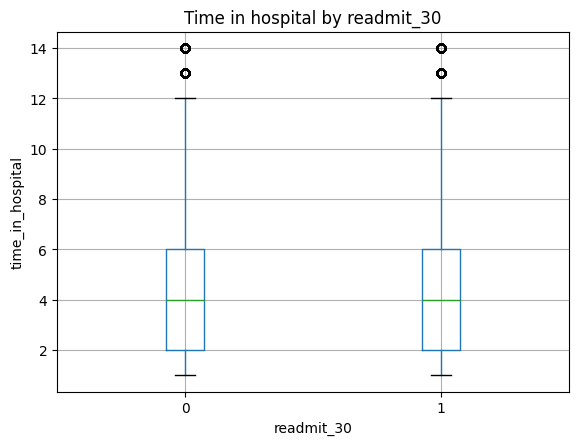

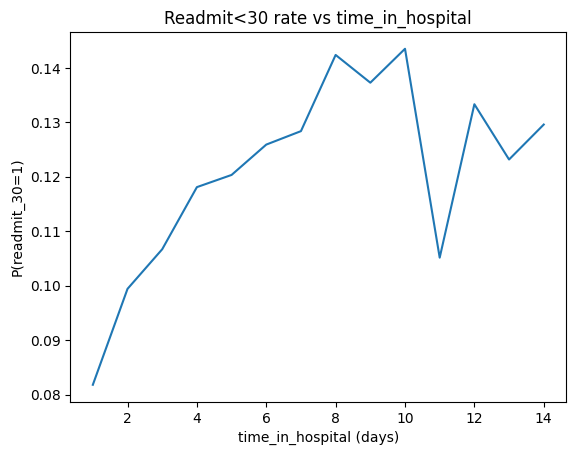

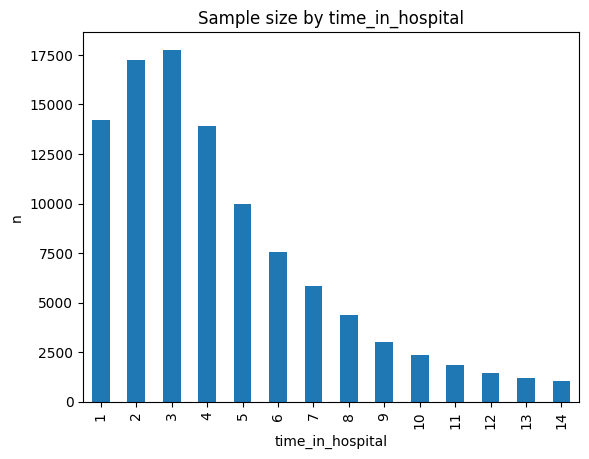

In [19]:
# hopsital time vs readmit30


# boxplot gives median (50th percentile, horiz-line in the box), middle 50% of data (called IQR, the box = Q1, 25th percentile, up to Q3, 75th percentile), whiskers (up to +-1.5*IQR beyond the box, which is the unusually far values), outliers as dots, min/max.
df.boxplot(column="time_in_hospital", by="readmit_30")
plt.title("Time in hospital by readmit_30")
plt.suptitle("")
plt.xlabel("readmit_30")
plt.ylabel("time_in_hospital")
plt.show()

# df.groupby("readmit_30")["time_in_hospital"].mean().plot(kind="bar") # “Do people who got readmitted stay longer in hospital?”
#df.groupby("time_in_hospital")["readmit_30"].mean().plot(kind="bar") # “As hospital stay increases, how does readmission risk change?”

#plt.ylabel("P(readmit_30=1)")
#plt.title("Readmit<30 by time_in_hospital")
#plt.show()

rate_by_los = (
    df.groupby("time_in_hospital")["readmit_30"]
      .agg(["mean","size"])
      .rename(columns={"mean":"rate","size":"n"})
      .sort_index()
)

rate_by_los["rate"].plot()
plt.title("Readmit<30 rate vs time_in_hospital")
plt.ylabel("P(readmit_30=1)")
plt.xlabel("time_in_hospital (days)")
plt.show()

rate_by_los["n"].plot(kind="bar")
plt.title("Sample size by time_in_hospital")
plt.ylabel("n")
plt.show()

#	•	“Length of stay distributions (median/IQR) are similar between readmit_30=0 and readmit_30=1.”
#	•	“Readmission risk increases with time_in_hospital up to ~10 days; later values are noisier likely due to smaller n.”


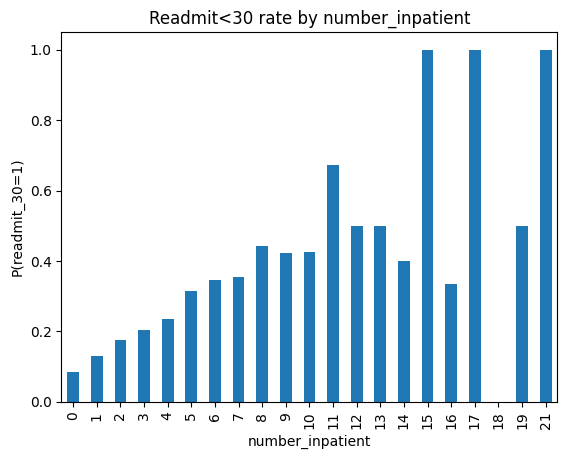

In [20]:
# number inpatient vs readmit30

rate_inp = df.groupby("number_inpatient")["readmit_30"].mean()
rate_inp.plot(kind="bar") 
plt.title("Readmit<30 rate by number_inpatient")
plt.ylabel("P(readmit_30=1)")
plt.show()



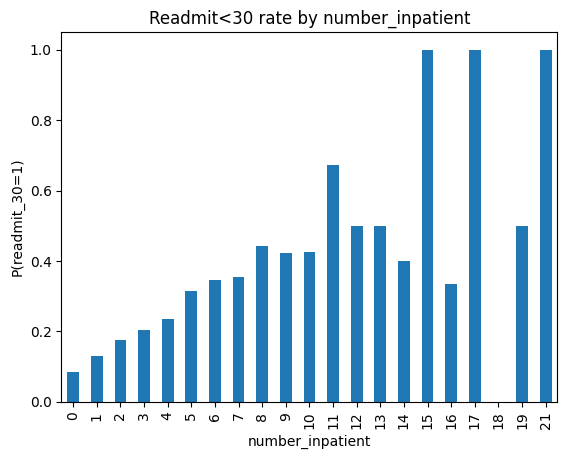

,rate,n
number_inpatient,,
11,0.673469,49
12,0.500000,34
13,0.500000,20
14,0.400000,10
15,1.000000,9
16,0.333333,6
17,1.000000,1
18,0.000000,1
19,0.500000,2


In [21]:
stats_inp = (
    df.groupby("number_inpatient")["readmit_30"]
      .agg(["mean","size"])
      .rename(columns={"mean":"rate","size":"n"})
      .sort_index()
)

stats_inp["rate"].plot(kind="bar")
plt.title("Readmit<30 rate by number_inpatient")
plt.ylabel("P(readmit_30=1)")
plt.show()

stats_inp.tail(10)   # see the tiny n’s causing spikes

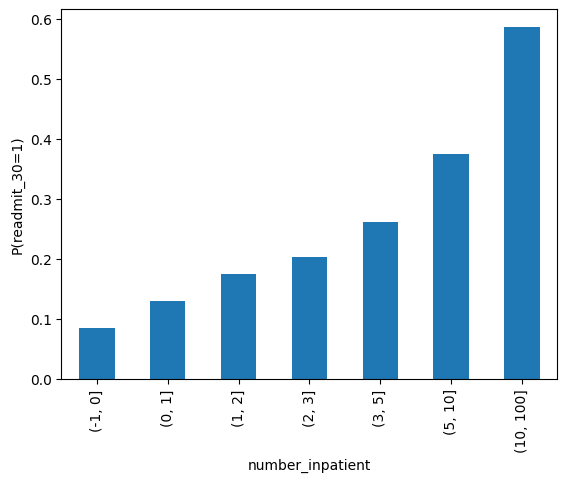

In [22]:
# data looks spiky

bins = pd.cut(df["number_inpatient"], bins=[-1,0,1,2,3,5,10,100])
out = df.groupby(bins, observed=True)["readmit_30"].agg(["mean","size"])
out.rename(columns={"mean":"rate","size":"n"})["rate"].plot(kind="bar")
plt.ylabel("P(readmit_30=1)")
plt.show()

 #  high number_inpatient values are rare → rates get noisy.
 # binned plot shows that: higher prior inpatient visits → higher readmit rate.


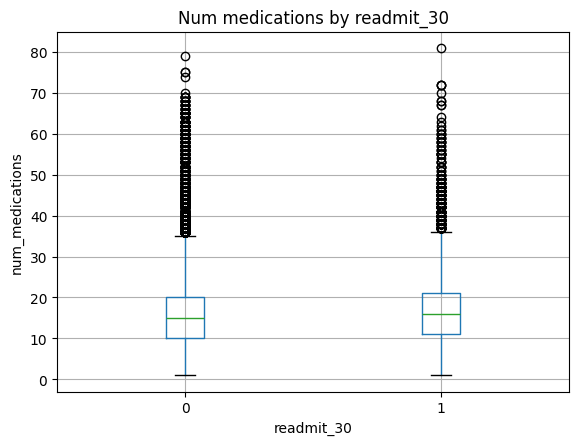

/var/folders/3x/f1qflpnn34b68r8pysx3plg00000gn/T/ipykernel_54310/1631577715.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(med_bins)["readmit_30"].mean().plot(kind="bar")


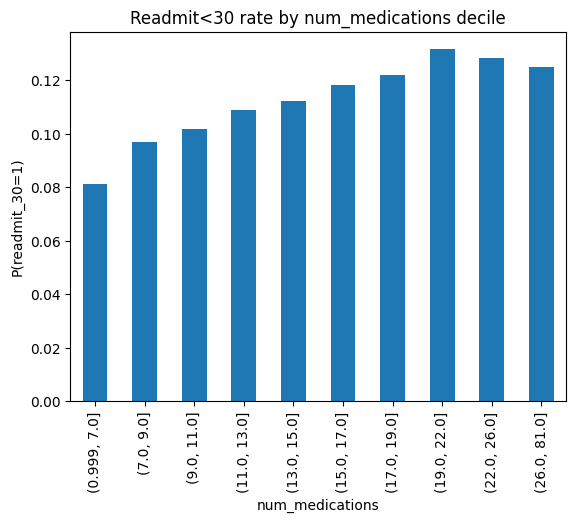

In [23]:
# number meds vs readmit30

df.boxplot(column="num_medications", by="readmit_30")
plt.title("Num medications by readmit_30")
plt.suptitle("")
plt.xlabel("readmit_30")
plt.ylabel("num_medications")
plt.show()

# pd.qcut = “quantile cut”. bins num_medications into 10 groups (deciles) s.t each bin has approx  same num of patients.  "drop" : if pandas can’t make 10 unique bins (bc repeated values), will reduce the number of bins instead of erroring.
med_bins = pd.qcut(df["num_medications"], q=10, duplicates="drop")
df.groupby(med_bins)["readmit_30"].mean().plot(kind="bar")
plt.title("Readmit<30 rate by num_medications decile")
plt.ylabel("P(readmit_30=1)")
plt.show()

# “Patients who were readmitted within 30 days tend to have slightly higher medication counts: the median and IQR of num_medications are shifted upward for readmit_30=1 compared to readmit_30=0, 
# and the decile-binned plot shows a generally increasing readmission rate as medication burden increases. 
# fluctuations at the highest bins are likely from smaller n. 

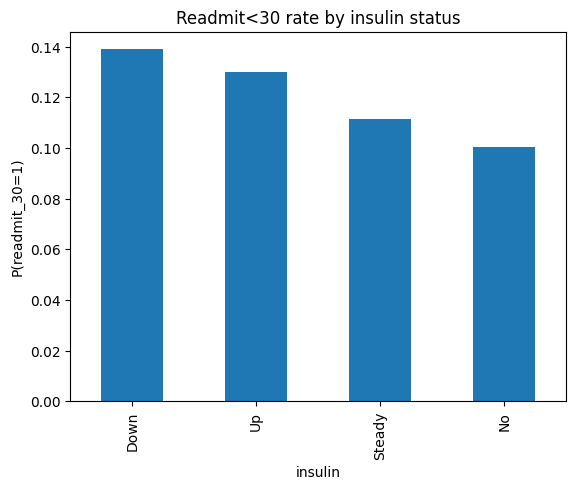

insulin
No        47383
Steady    30849
Down      12218
Up        11316
Name: count, dtype: int64

In [24]:
# insulin vs readmit30
# insulin is unordered
ins_rate = df.groupby("insulin")["readmit_30"].mean().sort_values(ascending=False) # orders insulin categories from highest readmission risk to lowest, worst to best.

ins_rate.plot(kind="bar")
plt.title("Readmit<30 rate by insulin status")
plt.ylabel("P(readmit_30=1)")
plt.xlabel("insulin")
plt.show()

df["insulin"].value_counts()

# this pattern does not mean changing insulin causes readmission. 
# more likely insulin status is a severity marker (sicker/more complex patients get insulin adjustments → higher baseline risk).

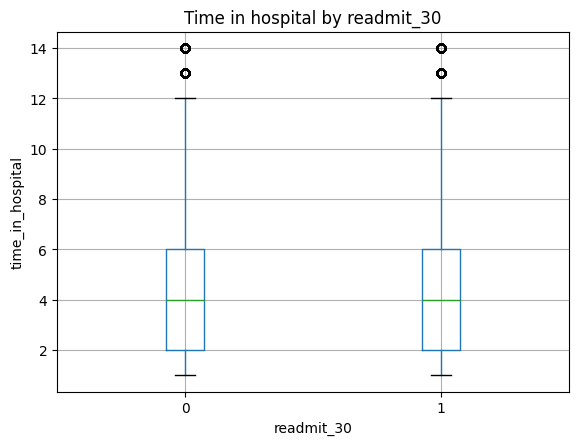

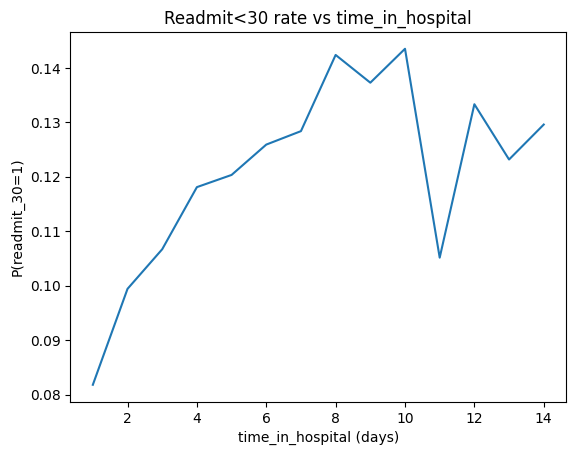

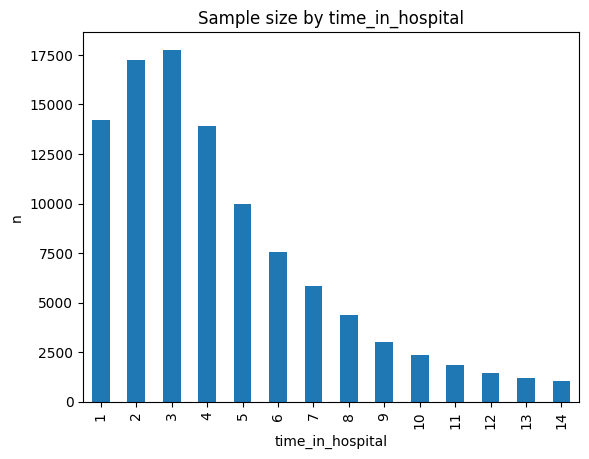

In [25]:
# hopsital time vs readmit30


# boxplot gives median (50th percentile, horiz-line in the box), middle 50% of data (called IQR, the box = Q1, 25th percentile, up to Q3, 75th percentile), whiskers (up to +-1.5*IQR beyond the box, which is the unusually far values), outliers as dots, min/max.
df.boxplot(column="time_in_hospital", by="readmit_30")
plt.title("Time in hospital by readmit_30")
plt.suptitle("")
plt.xlabel("readmit_30")
plt.ylabel("time_in_hospital")
plt.show()

# df.groupby("readmit_30")["time_in_hospital"].mean().plot(kind="bar") # “Do people who got readmitted stay longer in hospital?”
#df.groupby("time_in_hospital")["readmit_30"].mean().plot(kind="bar") # “As hospital stay increases, how does readmission risk change?”

#plt.ylabel("P(readmit_30=1)")
#plt.title("Readmit<30 by time_in_hospital")
#plt.show()

rate_by_los = (
    df.groupby("time_in_hospital")["readmit_30"]
      .agg(["mean","size"])
      .rename(columns={"mean":"rate","size":"n"})
      .sort_index()
)

rate_by_los["rate"].plot()
plt.title("Readmit<30 rate vs time_in_hospital")
plt.ylabel("P(readmit_30=1)")
plt.xlabel("time_in_hospital (days)")
plt.show()

rate_by_los["n"].plot(kind="bar")
plt.title("Sample size by time_in_hospital")
plt.ylabel("n")
plt.show()

#	•	“Length of stay distributions (median/IQR) are similar between readmit_30=0 and readmit_30=1.”
#	•	“Readmission risk increases with time_in_hospital up to ~10 days; later values are noisier likely due to smaller n.”
